In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.linalg import sqrtm
import pandas as pd
from sklearn.datasets import make_blobs
np.random.seed(123)
from sklearn.metrics import accuracy_score
import time

In [2]:
# https://stackoverflow.com/questions/20295046/numpy-change-max-in-each-row-to-1-all-other-numbers-to-0
def BKM(X, gamma, c, n_steps):
    '''
    Implementation of Balanced K-Means (Algorithm 2).
    
    Attributes:
    ---
    X: ndarray
        Matrix (dxn), d is the number of features, n is the number of observations.
    gamma: float
        Regularization parameter.
    c: int
        Number of clusters.
    n_steps: int
        Number of iterations.
    
    Returns:
    ---
    F: ndarray
        Matrix (nxc) with predicted clusters.
    '''
    n = X.shape[1]
    A = np.random.normal(size=(n, c))
    F = np.zeros_like(A)
    F[np.arange(len(A)), A.argmax(1)] = 1
    
    for i in range(n_steps):
        H = X @ F @ np.linalg.inv(F.T @ F)
        F_new = F.copy()
        j = 0
        while (np.linalg.norm(F_new - F) == 0) & (j < 10):
            G = (n * gamma * np.identity(n) - gamma * np.ones(n).reshape(-1, 1) @ (np.ones(n).reshape(-1, 1).T)) @ F
            Q = G + X.T @ H - 1/2 * np.ones(n).reshape(-1, 1) @ (np.ones(X.shape[0]).reshape(-1, 1).T) @ (H * H)
            F_new = np.zeros_like(F_new)
            F_new[np.arange(len(Q)), Q.argmax(1)] = 1
            j += 1
        F = F_new.copy()
    
    return F

In [3]:
# https://stackoverflow.com/questions/48312205/find-the-k-nearest-neighbours-of-a-point-in-3d-space-with-python-numpy

def construct_similarity_matrix(X, W, k):
    '''
    Calculates the similarity matrix.
    
    Attributes:
    ---
    X: ndarray
        Matrix (dxn), d is the number of features, n is the number of observations.
    W: ndarray
        Matrix XF inv(F'F) where F is cluster indicator matrix
    k: int
        Number of neighbours.
    
    Returns:
    ---
    B: ndarray
        Similarity matrix (nxm).
    '''
    B = np.zeros((X.shape[1], W.shape[1]))
    D = distance.squareform(distance.pdist(X.T)) # Matrix of distances n x n 
    closest = np.argsort(D, axis=1)
    closest_inds = closest[:, 1 : k+2] # Indices of rows closest to row i, n x k
    
    for i in range(B.shape[0]):
        for j in range(B.shape[1]):
            if j in closest_inds[i, :-1]:
                B[i, j] = (((D[i, closest_inds[i, -1]]) ** 2) - np.linalg.norm(X[:, i] - W[:, j]) ** 2) /\
                (k * ((D[i, closest_inds[i, -1]]) ** 2) - np.sum((D[i, closest_inds[i, :-1]]) ** 2))
            else:
                B[i, j] = 0
    
    return B

In [4]:
def FNC(X, k, m, gamma, n_steps):
    '''
    Implementation of Fast Normalized Cut (Algorithm 3) from the article.
    
    Attributes:
    ---
    X: ndarray
        Matrix (dxn), d is the number of features, n is the number of observations.
    k: int
        Number of neighbours.
    m: int
        Number of clusters for BKM.
    gamma: float
        Regularization parameter.
    n_steps: int
        Number of iterations.
    
    Returns:
    ---
    Y: ndarray
        Matrix (nxc) with predicted clusters.
    '''
    n = X.shape[1]
    clusters = BKM(X, gamma, m, 100)
    
    W = X @ clusters @ np.linalg.inv(clusters.T @ clusters)
    B = construct_similarity_matrix(X, W, k)
    delta = np.diag(np.sum(B, axis = 0).tolist())
    PPT = B @ np.linalg.inv(delta) @ B.T
    
    A = np.random.normal(size=(n, m))
    Y = np.zeros_like(A)
    Y[np.arange(len(A)), A.argmax(1)] = 1
    
    for k in range(n_steps):
        G = PPT @ Y @ np.linalg.inv(sqrtm(Y.T @ Y))
        s = np.zeros_like(Y)
        for i in range(s.shape[0]):
            for l in range(s.shape[1]):
                s[i, l] = ((Y[:, l].T @ G[:, l] + G[i, l] * (1 - Y[i, l])) /\
                np.sqrt(Y[:, l].T @ Y[:, l] + (1 - Y[i, l]))) - ((Y[:, l].T @ G[:, l] - Y[i, l] * G[i, l])/\
                np.sqrt(Y[:, l].T @ Y[:, l] - Y[i, l]))
        Y_new = np.zeros_like(Y)
        Y_new[np.arange(len(s)), s.argmax(1)] = 1
        Y = Y_new.copy()
    
        if np.linalg.det(Y.T @ Y) == 0:
            return Y
    
    return Y

#### Experiments
---

1. `sklearn` blobs

In [8]:
blobs = make_blobs()
X = blobs[0]
y = blobs[1]

Text(0.5, 1.0, 'BKM: Blobs Predictions')

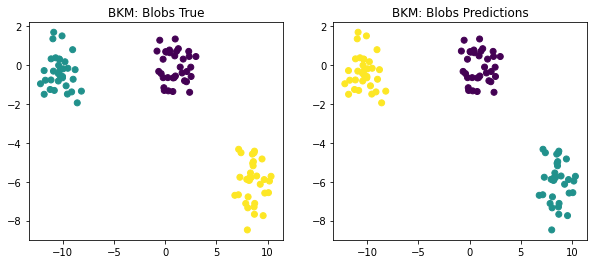

In [32]:
pred = BKM(X.T, 0.1, 3, 100)
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].scatter(X[:, 0], X[:, 1], c = y)
ax[0].set_title('BKM: Blobs True')
ax[1].scatter(X[:, 0], X[:, 1], c = np.argmax(pred, axis = 1))
ax[1].set_title('BKM: Blobs Predictions')

In [33]:
accuracy_score(y, np.argmax(pred, axis = 1))

0.34

Text(0.5, 1.0, 'FNC: Blobs Predictions')

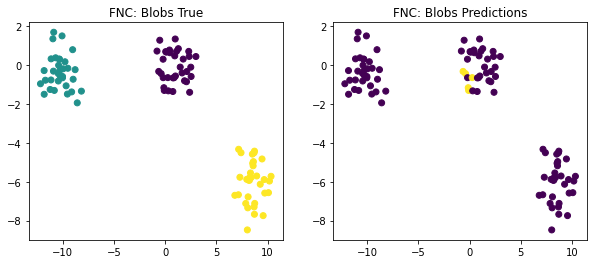

In [78]:
pred = FNC(X.T, 5, 3, 0.01, 100)
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].scatter(X[:, 0], X[:, 1], c = y)
ax[0].set_title('FNC: Blobs True')
ax[1].scatter(X[:, 0], X[:, 1], c = np.argmax(pred, axis = 1))
ax[1].set_title('FNC: Blobs Predictions')

In [80]:
accuracy_score(y, np.argmax(pred, axis = 1))

0.29

2. `isolet5`

In [92]:
data = pd.read_csv('Data/isolet5.data')

In [93]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [94]:
start = time.time()
pred = BKM(np.array(X).T, 0.1, 26, 100)
print(time.time() - start)

86.59085512161255


In [96]:
print('BKM accuracy:')
accuracy_score(y, np.argmax(pred, axis = 1))

BKM accuracy:


0.03273427471116817

In [97]:
start = time.time()
pred = FNC(np.array(X.T), 20, 26, 0.1, 20)
print(time.time() - start)

96.20871925354004


In [98]:
print('FNC accuracy:')
accuracy_score(y, np.argmax(pred, axis = 1))

FNC accuracy:


0.031450577663671375

3. `segments`

In [103]:
data = pd.read_csv('Data/segments.csv')

In [104]:
X = data.iloc[:, 1:-1]
y = data['class']
len(np.unique(y))

7

In [106]:
start = time.time()
pred = BKM(np.array(X).T, 0.1, 7, 100)
print('BKM time:')
print(time.time() - start)
print('BKM accuracy:')
print(accuracy_score(y, np.argmax(pred, axis = 1)))

BKM time:
109.36798191070557
BKM accuracy:


0.43722943722943725

In [107]:
start = time.time()
pred = FNC(np.array(X).T, 20, 7, 0.1, 100)
print('FNC time:')
print(time.time() - start)
print('FNC accuracy:')
print(accuracy_score(y, np.argmax(pred, axis = 1)))

FNC time:
99.59221363067627
FNC accuracy:
0.15800865800865802


4. `uspst.csv`

In [137]:
data = pd.read_csv('Data/uspst.csv')

In [138]:
X = data.iloc[:, 1:9]
y = data['7']
len(np.unique(y))

10

In [139]:
start = time.time()
pred = BKM(np.array(X).T, 0.1, 10, 100)
print('BKM time:')
print(time.time() - start)
print('BKM accuracy:')
print(accuracy_score(y, np.argmax(pred, axis = 1)))

BKM time:
1161.0087563991547
BKM accuracy:
0.08737997256515775


In [141]:
start = time.time()
pred = FNC(np.array(X).T, 20, 10, 0.1, 100)
print('FNC time:')
print(time.time() - start)
print('FNC accuracy:')
print(accuracy_score(y, np.argmax(pred, axis = 1)))

KeyboardInterrupt: 